# Computer Vision (911.908)

## <font color='crimson'>Tensor 101 (Tensor basics)</font>

**Changelog**:
- *Sep. 2020*: initial version (using PyTorch v1.6) 
- *Sep. 2021*: adaptations to PyTorch v1.9
- *Sep. 2022*: adaptations to PyTorch v1.12.1
- *Sep. 2024*: adaptations to Pytorch 2.4.0 (and mps support)

---

This introduction only provides the very basics of working with tensors (in **PyTorch**). For a more comprehensive overview (and introduction), see the PyTorch [documentation](https://pytorch.org/docs/stable/index.html) and the [tutorials](https://pytorch.org/tutorials/).

**Remark(s)**: all of the code is tested using the most recent version of PyTorch (v2.4). The lecture video (from COVID-19 times) might differ slightly in terms of the functions used, as some of the PyTorch API has changed.

---

## Content

- [Tensor types](#Tensor-types)
- [Writing device agnostic code](#Writing-device-agnostic-code)
- [Tensor creation and filling](#Tensor-creation-and-filling)
- [In-place operations](#In-place-operations)
- [Reduction operations](#Reduction-operations)
- [Indexing](#Indexing)
- [Slicing](#Slicing)
- [Views](#Views)
- [Expansion](#Expansion)
- [Images as tensors](#Images-as-tensors)
- [Operations](#Operations)
    - [Matrix-vector products](#Matrix-vector-products)
    - [Matrix-matrix products](#Matrix-matrix-products)
- [Interface to standard linear operations](#Interface-to-standard-linear-operations)    
    - [Solving linear least-squares regression](#Solving-linear-least-squares-regression)
- [Einops](#Einops)
---

Basically, a tensor is a *generalized matrix*. A ...

- ... 0d tensor is a scalar
- ... 1d tensor is a vector
- ... 2d tensor is a matrix
- ... 3d tensor can be interpreted as a vector of identically-sized matrices
- ... 4d tensor can be interpreted as a matrix of identically-sized matrices
- etc.

**Examples**

In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
print(mps_device)

mps


In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

print(torch.__version__)

2.6.0


In [4]:
t0 = torch.rand(1)        # scalar
t1 = torch.rand(1,10)     # 1x10 vector
t2 = torch.rand(5,10)     # 5x10 matrix 
t3 = torch.rand(3,5,10)   # vector of length 3 of 5x10 matrices
t4 = torch.rand(4,3,5,10) # 4x3 matrix of 5x10 matrices

We will use tensors to <font color='blue'>encode</font> the input/output signals, intermediate outputs, and also the parameters (internal states) of our models. 

In **PyTorch**, we have efficient tensor operations available on CPU/GPU, automatic differentiation (will be discussed later), etc. If a tensor is stored in memory on a certain device (GPU/CPU), operations are performed by that device.

## Tensor types

We have the following data types available for tensors:

- `torch.float16`
- `torch.float32`
- `torch.float64`
- `torch.uint8`
- `torch.int8`
- `torch.int16`
- `torch.int32`
- `torch.int64`

For `torch.float32`, the corresponding CPU tensor is `torch.FloatTensor` and the corresponding GPU tensor is `torch.cuda.FloatTensor`.

For a full listing see [here](https://pytorch.org/docs/stable/tensors.html). 

Note that `torch.Tensor` defaults to `torch.FloatTensor`. The preferred construction of tensors happens via `torch.tensor`.

---

In [5]:
# Sanity check
x = torch.Tensor()
x.dtype

torch.float32

## Writing device agnostic code

In some cases, we might want to run our code on CPU, in other cases we might want to run it on the GPU. Writing device-agnostic code is simple in PyTorch. We just set the `device` variable to the correct device that we have available. 

Note that if you have multiple GPUs, we can directly specify the GPU ID via `cuda:x`, e.g., `cuda:2`.




In [6]:
# use_gpu = True
# if torch.cuda.is_available() and use_gpu: 
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')

# print('Using:', device)
device = mps_device
print('Using:', device)


Using: mps


---

## Tensor creation and filling

In [47]:
# create an empty 8x8 tensor (i.e., a 8x8 matrix)
x = torch.empty(8, 8, 
                dtype=torch.float32, 
                device=device)

print(x)
print('Tensor type:', x.dtype)
print('Device:', x.device)

tensor([[ 0.4217,  2.1096,  2.4984,  1.5572, -0.7806, -0.9963, -0.0738,  1.4901],
        [ 0.3051,  0.5031, -0.2710,  0.9182, -0.2333, -0.3112, -0.0251,  0.8331],
        [ 0.8662, -2.0470, -1.9912,  1.4437,  0.5377,  0.6535,  0.9666,  0.3689],
        [ 1.2134,  0.5815,  1.3797,  0.4807,  0.5295, -0.1177, -0.4566, -0.9189],
        [-0.6124, -0.6150, -0.1027, -1.1169,  1.1079,  1.8945,  0.8696,  0.1630],
        [-0.6934,  0.7199, -1.5897, -0.2912, -1.2050,  1.5899,  0.2168, -0.3580],
        [-0.7588, -0.3001, -0.6039,  0.2783, -0.4918,  0.0255,  2.0306, -0.7126],
        [ 1.9968,  0.4390, -0.3322,  1.2045, -0.0088, -1.5652,  0.1114, -0.0300]],
       device='mps:0')
Tensor type: torch.float32
Device: mps:0


We see that we have *uninitialized data*. (To the best of my knowledge, there is no direct way of checking if a tensor is *uninitialized*, though).

In [48]:
# 3x2 tensor filled with zeros
x = torch.zeros(3, 2, 
                device=device) 
print(x)
print('Tensor type', x.dtype)
print('Device:', x.device)

# tensor of same size as x, filled with zeros
y = torch.zeros_like(x).to(device) 
print('Tensor type:', y.dtype)
print('Device:', y.device)
print(x.size())
print(y.size())

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='mps:0')
Tensor type torch.float32
Device: mps:0
Tensor type: torch.float32
Device: mps:0
torch.Size([3, 2])
torch.Size([3, 2])


In [19]:
# create 3x2x10 tensor (i.e., 3 matrices of size 2x10) of all ones
x = torch.ones(3, 2, 10, 
               device=device)
print(x)
print(x.size())
print('Tensor type:', x.dtype)
print('Device:', x.device)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], device='mps:0')
torch.Size([3, 2, 10])
Tensor type: torch.float32
Device: mps:0


We can also create tensors from numpy arrays. Unless we specify the tensor type directly, the `numpy` array type is inherited.

In [20]:
x = np.array(
    [
        [1.,2.,3.],
        [4.,5.,6.]
    ], dtype=np.float32)

# create tensor from numpy array
t = torch.tensor(x).to(device)
print(t)
print(t.dtype)

x = np.array(
    [
        [1,2,3],
        [4,5,6]
    ], dtype=np.float32)
t = torch.tensor(x, device=device)
print(t)
print(t.dtype)
print(t.size())

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='mps:0')
torch.float32
tensor([[1., 2., 3.],
        [4., 5., 6.]], device='mps:0')
torch.float32
torch.Size([2, 3])


In case you want to share the memory of the numpy array and the tensor, you can use `torch.from_numpy`, see below:

In [21]:
x = np.array(
    [
        [1,2,3],
        [4,5,6]
    ], dtype=np.float32)
u = torch.from_numpy(x)

# adjust x's (0,0)-element from 1 to 3
x[0,0] = 3
# check tensor
print(u)

tensor([[3., 2., 3.],
        [4., 5., 6.]])


---

## In-place operations

Operations that operate directly on the tensor and *do not* make a copy.

In [22]:
x = torch.empty(3, 1, device=device, dtype=torch.float32)
y = torch.empty(3, 1, device=device, dtype=torch.float32)
z = torch.empty(3, 1, device=device, dtype=torch.float32)

x.fill_(3)  # filled with ALL ones
y.zero_()   # filled with ALL zeros
z.normal_() # filled with elements drawn from N(0,1) - i.e., a standard Gaussian

print(x)
print(y)
print(z)

tensor([[3.],
        [3.],
        [3.]], device='mps:0')
tensor([[0.],
        [0.],
        [0.]], device='mps:0')
tensor([[-1.5884],
        [ 0.8093],
        [-0.6194]], device='mps:0')


**Note**: In-place operations are post-fixed with a `_`, such as `x.zero_()` or `x.fill_(1.0)` or `x.normal_()`. The latter fills the tensor with values sampled from a standard Gaussian $\mathcal{N}(0,1)$.

---

## Reduction operations

In [83]:
x = torch.zeros(3, 2).normal_()
print(x)

s0 = x.sum()  # sum over all tensor values
s1 = x.mean() # mean over all tensor values
s2 = x.std()  # computed the standard deviation over all tensor values
s3 = x.norm() # matrix norm of x (in that case Frobenius norm)

print(s0.item())
print(s1.item())
print(s2.item())
print(s3.item())

tensor([[-1.0018,  1.1316],
        [-0.3483,  0.7161],
        [ 0.9322,  1.5727]])
3.0024573802948
0.5004095435142517
0.9754967093467712
2.502084732055664


Note that While `s0` ... `s3` are scalars, they are encoded as a 0d tensor. To get a Python number, we call `.item()`.

We can also perform these operations over specific dimensions.

In [89]:
x = torch.rand(10,1,10)

# x contains 10 1x10 vectors - lets sum over the elements of each vector
sum_v0 = x.sum(dim=2)
# check first element
sum_v1 = x[0,...].sum()
sum_v2 = x[0].sum() # another variant of the previous line

assert sum_v0[0] == sum_v1
assert sum_v0[0] == sum_v2

---

## Indexing

Indexing starts at 0 (as usual). Say you have a $3 \times 2$ tensor `x`. The dimensionality along the first dimension is $3$ and along the second dimension $2$. To get the value at $(i,j)$, we write 
`x[i,j]`. Similarly, if we have a $3 \times 3 \times 2$ tensor, we get the value at $(i,j,k)$ via 
`x[i,j,k]`.

In [91]:
x = torch.rand(3, 3, 2, 
               device=device)
print(x)
print(x[0,1,1].item()) # .item() returns the value of the tensor (needs to be a scalar) as a regular Python number

tensor([[[0.2505, 0.1293],
         [0.6392, 0.3525],
         [0.7230, 0.5328]],

        [[0.4796, 0.8410],
         [0.7876, 0.6743],
         [0.3921, 0.8187]],

        [[0.1938, 0.4000],
         [0.1245, 0.4822],
         [0.1831, 0.8305]]])
0.35250163078308105


In [92]:
x = torch.empty(3, 10, 12, 
               device=device).normal_()
print(x[0,8,2])

tensor(0.2642)


---
## Slicing

We can also extract certain parts of a tensor, using *slicing*, e.g., if `x = torch.rand(3,10,12)`, we have three $10 \times 12$ matrices in this tensor, or, a vector (of length 3) of $10 \times 12$ matrices. To extract the first vector element (i.e., the first $10 \times 12$ matrix), we write

In [11]:
x = torch.rand(3,10,12)
print(x.size())
z = x[0,:,:]    # equivalent to x[0,...] or x[0]
print(z.size())

torch.Size([3, 10, 12])
torch.Size([10, 12])


**Note**: If we modify a value in `z`, we also modify the value in `x` (unless we clone, see below).

In [12]:
print('Without cloning ...')
x = torch.rand(1,2)
print('x (original):', x)
z = x
z[0,0] = 1.
print('x (original, after modification of z):', x)
print('z:', x)
print()

x = torch.rand(1,2)
print('With cloning ...') 
print('x (original):', x)
z = x.clone()
z[0,0] = 1.
print('x (original, after modification of z):', x)
print('z:', z)

Without cloning ...
x (original): tensor([[0.0351, 0.9482]])
x (original, after modification of z): tensor([[1.0000, 0.9482]])
z: tensor([[1.0000, 0.9482]])

With cloning ...
x (original): tensor([[0.3115, 0.6199]])
x (original, after modification of z): tensor([[0.3115, 0.6199]])
z: tensor([[1.0000, 0.6199]])


Slicing also allows to set all values of a slice simultaneously:

In [13]:
x = torch.empty(3, 1, 2, 
               device=device).normal_()

print(x)
x[0,:,:] = 2
print(x)
print()

x[0,:,:].zero_()
print(x)

tensor([[[ 0.4124, -1.8629]],

        [[-0.4894,  0.4083]],

        [[ 0.0624, -0.1299]]], device='mps:0')
tensor([[[ 2.0000,  2.0000]],

        [[-0.4894,  0.4083]],

        [[ 0.0624, -0.1299]]], device='mps:0')

tensor([[[ 0.0000,  0.0000]],

        [[-0.4894,  0.4083]],

        [[ 0.0624, -0.1299]]], device='mps:0')


---

## Views

We can also easily create different *views* of a tensor. A common procedure is to view the tensor as a vector, which can easily be done via: 

In [99]:
x = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
print(x)
print(x.size())
print(x.dtype)
print()

# 1d view
v0 = x.view(-1)
print(v0)
print()

# sanity check
print(x.untyped_storage().data_ptr() == v0.untyped_storage().data_ptr())

# view as 3x2 tensor
v1 = x.view(3,-1)
print(v1)
print()

# ... or more explicitely (if we know the exact size)
v2 = x.view(3, 2)
print(v2)
print()

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])
torch.float32

tensor([1., 2., 3., 4., 5., 6.])

True
tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])



In the first example above, `v0` now is a 1d view of the tensor `x`. Again, modifying `v0` modifies `x`. Also, the original size of `x` does not change.

---

## Expansion

*Expansion* expands singleton dimensions to a larger size (by creating a new view *without* memory consumption). In the next example we have a $2 \times 3$ tensor and want to expand this one to a $3 \times 2 \times 3$ tensor, i.e., expansion along the first singleton dimension.

In [21]:
x = torch.tensor(
    [
        [1,2,3],
        [4,5,6]
    ])

print(x.size())
print()

y = x.expand(5,2,3)
print(y)
print(y.size())

# check storage to see that the underlying data did not get modified
print(x.untyped_storage().data_ptr() == y.untyped_storage().data_ptr())

torch.Size([2, 3])

tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]]])
torch.Size([5, 2, 3])
True


Using `unsqueeze` we can also expand tensors by adding ONE singleton dimension. Below is an example of unsqueezing along dimension 0. The opposite operation is `squeeze`, obviously :)

In [22]:
x = torch.tensor(
    [
        [1,2,3],
        [4,5,6]
    ])
x = x.unsqueeze(0)
print(x.size())
x = x.squeeze()
print(x.size())

torch.Size([1, 2, 3])
torch.Size([2, 3])


---

## Images as tensors

Images are just tensors ... it's that simple!

In [103]:
import torch
import torchvision

# download a popular computer vision dataset
cifar = torchvision.datasets.CIFAR10(
    '../data/cifar10/', 
    train = False,
    download = True)

Files already downloaded and verified


`cifar` is an instance of `torchvision.dataset`. We can access it's elements via `cifar[idx]` and get a tuple of `(data, label)`. `data` is a `PIL` image, `label` should be an integer. 

In [107]:
img = cifar[600][0]
lab = cifar[600][1]
print(type(img))
print(type(lab))

<class 'PIL.Image.Image'>
<class 'int'>


Internally, `cifar` has a `data` class variable which holds all images in a numpy array. Lets convert this into a tensor:

In [108]:
print(cifar.data.shape)
print(type(cifar.data)) # to see that we have a numpy array underneath

# we use permute to switch dimensions, as originally images are in the format channels x W x H
x = torch.from_numpy(cifar.data).permute(0, 3, 1, 2).float()
print(x.type())
print(x.size())

(10000, 32, 32, 3)
<class 'numpy.ndarray'>
torch.FloatTensor
torch.Size([10000, 3, 32, 32])


So, using the `torchvision` module, we have just loaded *all* images from the CIFAR-10 testing set (since we specified `train=False`). CIFAR-10 images are RGB images (hence 3 color channels) and we have 10,000 images available. Consequently, we get a $10000 \times 3 \times 32 \times 32$ tensor.

This is the convention for multi-channel images in PyTorch, i.e., nr. of images times channels times width times height. For visualization using `matplotlib` we need to permute the channels, though:

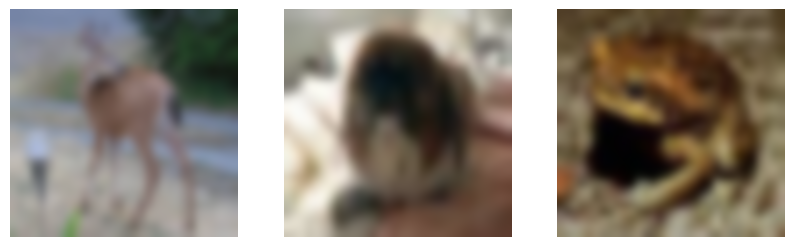

In [109]:
import matplotlib.pyplot as plt

def show(img):
    npimg = img.numpy()
    plt.imshow(
        np.transpose(npimg, (1, 2, 0)), 
        interpolation='bicubic')
    plt.axis('off')

plt.figure(figsize=(10,3))
plt.subplot(131)
show(x[100,:,:,:]/255.)
plt.subplot(132)
show(x[200,:,:,:]/255.)
plt.subplot(133)
show(x[300,:,:,:]/255.)

PyTorch also has its own convenience methods to quickly visualize images in a tensor on a grid (using `torchvision.utils.make_grid`. E.g., we can narrow the tensor containing all CIFAR10 testing images along its first dimension to only contain 48 images.

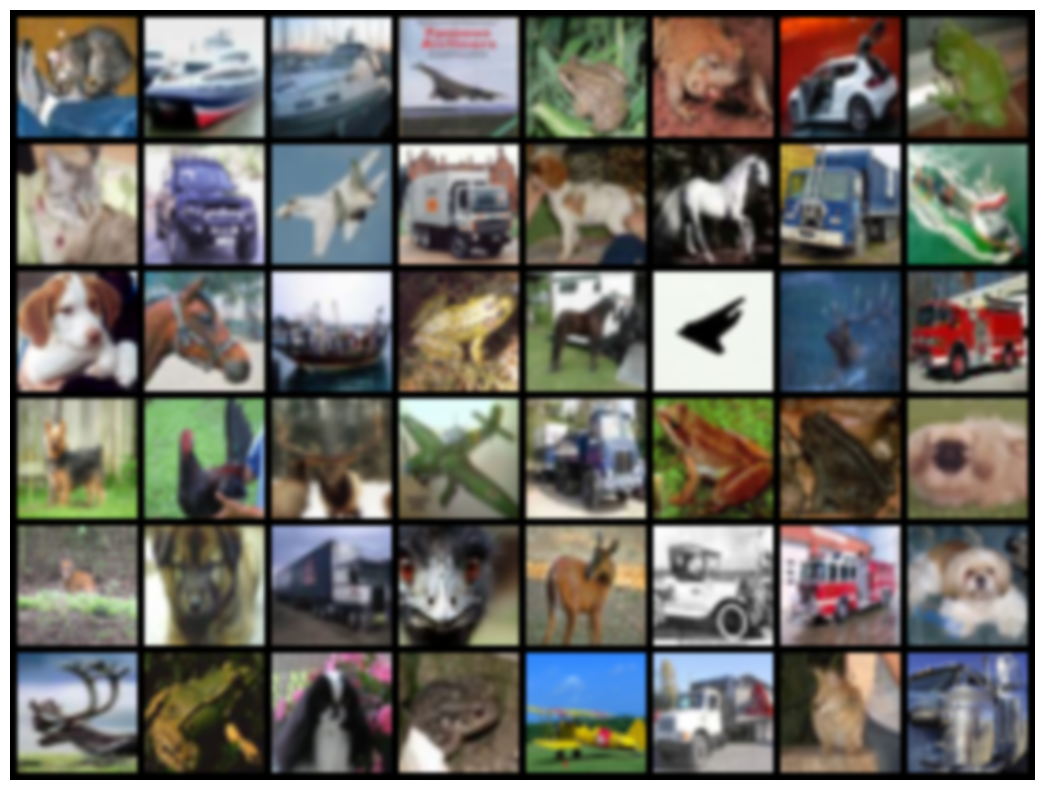

In [34]:
from torchvision.utils import make_grid

y = x.narrow(0, 0, 48).float()
collage = make_grid(y, normalize=True)
plt.figure(figsize=(20,10))
show(collage)

---

## Operations

### Point-wise operations

In [35]:
# Multiplication
x = torch.ones(3,1)*2
y = torch.ones(3,1)*4
print(x)
print(y)

z = x*y
print(z)

tensor([[2.],
        [2.],
        [2.]])
tensor([[4.],
        [4.],
        [4.]])
tensor([[8.],
        [8.],
        [8.]])


In [36]:
# Squaring
x = torch.ones(3,1)*2.
print(x**2)
print(torch.pow(x,2.)) # equivalent

tensor([[4.],
        [4.],
        [4.]])
tensor([[4.],
        [4.],
        [4.]])


### Matrix-vector products

In [112]:
M = torch.tensor(
    [
        [1.,2,3],
        [4,5,6],
        [7,8,0]
    ]).to(device)
y = torch.tensor([1.,2,3]).to(device)
print(M.mv(y))

# Note, M*y multiplies each row of M with y pointwise (uncomment the line below to check)
# print(M*y)

tensor([14., 32., 23.])


### Matrix-matrix products

Matrix-matrix products are written via `@`. For a 2d tensor `M`, we can also equivalently write `M.mm(M)` to compute the matrix multiplication of `M` with itself, or `torch.mm(M,M)`.

In [40]:
print(M @ M)         # Variant 1
print(M.mm(M))       # equivalent to Variant 1 
print(torch.mm(M,M)) # equivalent to Variant 1

tensor([[30., 36., 15.],
        [66., 81., 42.],
        [39., 54., 69.]], device='mps:0')
tensor([[30., 36., 15.],
        [66., 81., 42.],
        [39., 54., 69.]], device='mps:0')
tensor([[30., 36., 15.],
        [66., 81., 42.],
        [39., 54., 69.]], device='mps:0')


Now, what if we have 10 $3 \times 3$ matrices in tensor `A` and also 10 $3 \times 3$ matrices in tensor `B` and want to compute all matrix products in one operation? This is pretty simple, as `A@B` will check if the last two dimenions of `A` and `B` are compatible and then perform the matrix multiplications.

In [122]:
50000*50*50*4/1024/1024

476.837158203125

In [123]:
import time
N=50
A = torch.rand(50000,N,N,device=device)
B = torch.rand(50000,N,N,device=device)
t0 = time.time()
C = A@B
print(C.shape)
print('Time[s]:', time.time()-t0)

# # Here's a bad, bad way of doing the same - DON'T DO THIS 
t0 = time.time()
C = torch.zeros(50000,N,N,device=device)
for i in range(50000):
    C[i] = A[i]@B[i]
print('Time[s]:', time.time()-t0)

torch.Size([50000, 50, 50])
Time[s]: 0.16329693794250488
Time[s]: 0.29514288902282715


---
## Interface to standard linear operations

For instance, we can use `torch.lstsq` as a **least-squares** problem solver. Say you want to solve

$$ 
 \min_{\mathbf{X}}  \|\mathbf{A}\mathbf{X}-\mathbf{B}\|_2.
$$

for a given full-rank matrix $\mathbf{A}$ ($m \times n$) and a matrix $\mathbf{B}$ ($m \times k$). 

In the following **example**, $\mathbf{B}$ is of size $3 \times 1$ and $\mathbf{A}$ is of size $3 \times 3$. Both matrices will be filled with values from a standard Normal distribution.

In [55]:
B = torch.empty(3,1).normal_()   # 2d tensor of size 3x1 (i.e., a vector)
A = torch.empty(3,3).normal_()   # 2d tensor (matrix)

#
# Note: in the lecture video, we are using torch.lstsq; as of PyTorch v1.9 torch.linalg.lstsq
#       should be used as, torch.lstsq is deprecated.
#       

# solve min_X ||AX - B||_2
x,_,_,_ = torch.linalg.lstsq(A,B) 

# some arbitrary vector just as a sanity check
z = torch.rand(3,1)

# Note: both x and z are 3x1 matrices (2d) tensors representing vectors
# Hence, we use mm() to compute matrix-matrix products.

Ax = A.mm(x)  
Az = A.mm(z) 

print('Norm (using x): {:.5f}'.format(torch.norm(Ax.view(3,) - B.view(3,)).item()))
print('Norm (using z): {:.5f}'.format(torch.norm(Az.view(3,) - B.view(3,)).item()))

Norm (using x): 0.00000
Norm (using z): 3.13239


**Another example**: Say we have three points in 2D as $(x,y)$ tuple: $(0,6)$, $(2,0)$, and $(1,0)$ and we want to fit a line of the form $y = kx+b$. In case our points would be on that line, the following equations would be satisfied:

$$
6 = k\cdot 0+b,\quad 0 = k\cdot 2+b,\quad 0=k\cdot2+b
$$

As the points **do not** lie on a line, we compute the best least-squares fit:

In [133]:
A = torch.tensor([[0,1.],[1,1],[2,1]])
B = torch.tensor([[6.],[0],[0]])

print(A.shape)
print(B.shape)

solution = torch.linalg.lstsq(A,B)[0]
print(solution.shape)

#print(f'k={x[0].item()}, b={x[1].item()}')
#print(solution)


torch.Size([3, 2])
torch.Size([3, 1])
torch.Size([2, 1])


The next example below is a bit more interesting.

### Solving linear least-squares regression

We are given 

$$(x_1,y_1), \ldots, (x_N,y_N)$$

with $(x_i,y_i) \in \mathcal{Z} = \mathbb{R} \times \mathbb{R}$ and want to fit the best-fitting **line** through this data (in a least-squares sense), i.e., a model of the form

$$ f(x;a,b) = ax + b$$

This linear least squares **optimization problem** (in the parameters $a,b$) can be written as

$$ \arg\min_{a,b} \frac{1}{N} \sum_{i=1}^N (ax_i +b -y_i)^2$$

i.e., we try to minimize the sum of squared residuals $(ax_i +b -y_i)$.

Upon obtaining a solution, we can put in a (previously unseen) $x^*$ and predict the corresponding value $y^*$ via 

$$f(x^*; a,b)=\hat{y}$$

The toy data we use is taken from the [Isotonic Regression](https://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) example from `sklearn` (to find a non-decreasing approximation function).

In [65]:
from sklearn.utils import check_random_state

N = 100
x = np.arange(N)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(N,)) + 50. * np.log1p(np.arange(N))

Note that `np.log1p(x)` returns $\log(1+x)$ and the toy data can obviously not modeled by a linear function - However, for our purposes this is *linear enough* as we will see.

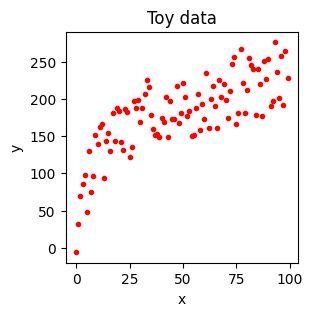

In [66]:
plt.figure(figsize=(3,3))
plt.plot(x,y,'r.')
plt.xlabel('x');
plt.ylabel('y');
plt.title('Toy data');

**Setting up the problem**    

First, we construct our $N \times 2$ data matrix $\mathbf{A}$ as follows:

$$\mathbf{A} = \left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right)$$

Note the additional column of all 1's - this is to include the offset (b).
We put our targets $y_i$ in a $N \times 1$ matrix (i.e., a colum vector)

$$\mathbf{B} = \left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)$$

**Goal**:

$$
\left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right) 
\left(\begin{matrix}
a \\
b
\end{matrix}
\right)
\approx
\left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)
$$

Hence, encoding $\mathbf{X} = [a,b]^\top$, we want to solve

$$ \min_{\mathbf{X}} \frac{1}{N} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2^2$$

Note that this minimization problem is equivalent to 

$$ \min_{\mathbf{X}} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2$$

as square-rooting the norm is a monotonic transformation (i.e., it does not matter which one we minimize). The latter, however, fits our setting of the `torch.lstsq()` function. Similarly, the missing $1/N$ term does not change the optimization result.

In [67]:
device = 'cpu' 

data_x = torch.empty(N, 2, dtype=torch.float)
data_y = torch.empty(N, 1, dtype=torch.float)

data_x[:,0] = torch.tensor(x)
data_x[:,1] = 1.
data_y[:,0] = torch.tensor(y)

data_x = data_x.to(device)
data_y = data_y.to(device)

In this example `data_x` acts as our matrix $\mathbf{A}$, and `data_y` acts as our matrix $\mathbf{B}$. $\mathbf{A}$ is of size $(m,n) = (N,2)$, $\mathbf{B}$ of size $(n,k) = (N,1)$. According to the documentation the returned solution has size $(\max(m,n), k)$, so we will get a matrix of size $(100,1)$ back.

In [69]:
# As above, in the lecture video we are using torch.lstsq (where arguments need to be switched)
alpha, _,_,_ = torch.linalg.lstsq(data_x, data_y)
print(alpha.size())

torch.Size([2, 1])


Again, according to the documentation, the first $n$ (in our case $n=2$) rows contain the solution, the remaining $100-2$ entries contain the residual sum of squares for the solution.

In [70]:
a = alpha[0,0].item()
b = alpha[1,0].item()
print(a,b)

1.3134794235229492 115.08245086669922


Just a quick comparison to the actual isotonic regression example in `sklearn`:

In [71]:
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)

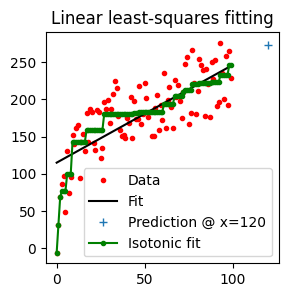

In [72]:
plt.figure(figsize=(3,3))
plt.plot(x, y, 'r.', label='Data')
plt.plot(x, a*x + b, 'black', label='Fit')
plt.plot(120, a*120+b, '+', label='Prediction @ x=120')
plt.plot(x, y_, 'g.-', label='Isotonic fit')
plt.legend();
plt.title('Linear least-squares fitting');

In [73]:
from sklearn.metrics import r2_score

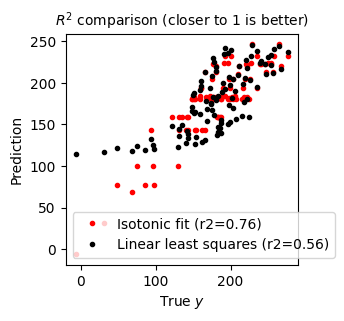

In [74]:
plt.figure(figsize=(3,3))
plt.plot(y,y_,'.',color='red', label='Isotonic fit (r2={:.2f})'.format(r2_score(y, y_)))
plt.plot(y,a*x+b,'.',color='black', label='Linear least squares (r2={:.2f})'.format(r2_score(y, a*x+b)))
plt.xlabel('True $y$');
plt.ylabel('Prediction');
plt.legend();
plt.title(r'$R^2$ comparison (closer to 1 is better)', fontsize=10);

### Einops

Checkout [einops](https://einops.rocks/), a library for flexible tensor operations with very readable code.

In [24]:
import einops
print(einops.__version__)

0.8.0


Consider the following example: you have a tensor of size `10 x 3 x 12 x 12`, e.g., 10 RGB images of width/height equal to 12, and you want to reshape that tensor as a tensor of size `10 x 432`. Essentially, you are vectorizing everything beyond dimension 0.

In [76]:
from einops import rearrange, repeat

tensor([1.7979, 1.5755, 1.7156, 1.6307, 2.4014, 2.3627, 2.0338, 1.8840, 2.0385,
        1.3141])

In [77]:
# example tensor
x = torch.randn(10,3,12,12)

# the "classic" way
y = x.view(x.shape[0], -1)
print(y.shape)

# the einops way
y = rearrange(x, 'b c h w -> b (c h w)')
print(y.shape)

torch.Size([10, 432])
torch.Size([10, 432])


... and an example using `repeat` from `einops`.

In [78]:
x = torch.rand(2,3)

# the pytorch way
y = torch.repeat_interleave(x,3,dim=0)
print(y)
print(y.shape)
print()

# the einops way
y = repeat(x, 'h w -> (nrep h) w', nrep=3)
print(y)
print(y.shape)
print()

tensor([[0.8839, 0.9120, 0.3198],
        [0.8839, 0.9120, 0.3198],
        [0.8839, 0.9120, 0.3198],
        [0.2189, 0.4584, 0.0505],
        [0.2189, 0.4584, 0.0505],
        [0.2189, 0.4584, 0.0505]])
torch.Size([6, 3])

tensor([[0.8839, 0.9120, 0.3198],
        [0.2189, 0.4584, 0.0505],
        [0.8839, 0.9120, 0.3198],
        [0.2189, 0.4584, 0.0505],
        [0.8839, 0.9120, 0.3198],
        [0.2189, 0.4584, 0.0505]])
torch.Size([6, 3])



You judge for yourself, which of the code lines above are more readable.